
Here is a public dataset of "mammographic masses" coming from https://archive.ics.uci.edu/ml/datasets/Mammographic+Mass


# Information about the Dataset:

Mammography is the most effective method for breast cancer screening 
available today. However, the low positive predictive value of breast 
biopsy resulting from mammogram interpretation leads to approximately 
70% unnecessary biopsies with benign outcomes. To reduce the high 
number of unnecessary breast biopsies, several computer-aided diagnosis 
(CAD) systems have been proposed in the last years.These systems 
help physicians in their decision to perform a breast biopsy on a suspicious 
lesion seen in a mammogram or to perform a short term follow-up 
examination instead. 
This data set can be used to predict the severity (benign or malignant) 
of a mammographic mass lesion from BI-RADS attributes and the patient's age. 
It contains a BI-RADS assessment, the patient's age and three BI-RADS attributes 
together with the ground truth (the severity field) for 516 benign and 
445 malignant masses that have been identified on full field digital mammograms 
collected at the Institute of Radiology of the 
University Erlangen-Nuremberg between 2003 and 2006. 
Each instance has an associated BI-RADS assessment ranging from 1 (definitely benign) 
to 5 (highly suggestive of malignancy) assigned in a double-review process by 
physicians. Assuming that all cases with BI-RADS assessments greater or equal 
a given value (varying from 1 to 5), are malignant and the other cases benign, 
sensitivities and associated specificities can be calculated. These can be an 
indication of how well a CAD system performs compared to the radiologists. 

# Dataset Metrics

Class Distribution: benign: 516; malignant: 445 

There are 961 samples of masses detected in mammograms. Each sample has 6 attributes: BI-RADS assessment, Age, Shape, Margin, Density, and Seversity

BI-RADS Assessment- 1 to 5 (ordinal) (non-predictive)

Age- Age in years (integer)

Shape(shape of mass)- 1(round), 2(oval), 3(lobular), 4(irregular) (nominal)

Margin(mass margin)- 1(circumscribed), 2(microlobulated), 3(obscured), 4(ill-defined), 5(spiculated) (nominal)

Density(mass density)- 1(high), 2(iso), 3(low), 4(fat-containing) (ordinal)

Severity- 0(benign), 1(malignant) (binominal)

More information from the dataset can be read from "mammographic_masses.names.txt"

Initially we must import required libraries and read/clean in the data for scientific processing.

In [180]:
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn import neighbors
import matplotlib.pyplot as pp
import warnings
warnings.filterwarnings('ignore')

cols = ["BI-RADS", "Age", "Shape", "Margin", "Density", "Severity"]

mmg = pd.read_csv("mammographic_masses.data.txt", na_values=["?"], names = cols)

data = np.array(mmg.to_records())

We establish the names of each feature and store the data from a csv.

We will now see the description of the dataset and drop any rows with '?'. Although it is not always the best practice to drop rows with missing or confusing values, we will do it for the sake of the classifiers and also because we do not have too much insight on the data.

In [181]:


mmg.dropna(inplace=True)
mmg.describe()


,BI-RADS,Age,Shape,Margin,Density,Severity
count,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000
mean,4.393976,55.781928,2.781928,2.813253,2.915663,0.485542
std,1.888371,14.671782,1.242361,1.567175,0.350936,0.500092
min,0.000000,18.000000,1.000000,1.000000,1.000000,0.000000
25%,4.000000,46.000000,2.000000,1.000000,3.000000,0.000000
50%,4.000000,57.000000,3.000000,3.000000,3.000000,0.000000
75%,5.000000,66.000000,4.000000,4.000000,3.000000,1.000000
max,55.000000,96.000000,4.000000,5.000000,4.000000,1.000000


According to the description of our dataset, when looking at the percentiles of age, the majority of samples are between 45-70 years. A standard deviation of 14.67 proves that each of 830 samples the age is spread through a wide range. We can focus less on the description of other features because they are ordinal or nominal; however it is important to notice that density is 3.0 (low) in all percentiles showing possible signifcance? 

Predicting severity if the mammographic mass is benign or malignant is the goal of our binary classification. Additionally we must load all other features into a data structure that can be easily be subject to scientific computations(numpy array).

In [182]:


y = mmg["Severity"].values
X = mmg[["BI-RADS", "Age", "Shape", "Margin", "Density"]].values

#X = preprocessing.StandardScaler().fit_transform(X)

The first binary classification technique will be using a linear support vector machine with hyperparamater C tuned to 1.0. We print the error of the SVM and precision/recall

In [183]:
from sklearn.metrics import classification_report

n, d = X.shape
y_predsvm = np.zeros((n, 1))
y_temp = y.reshape(-1, 1)
for i in range(n):
    all_b_i = range(0, i) + range(i+1, n)
    X_t = X[all_b_i]
    y_t = y_temp[all_b_i]
    svc = svm.SVC(kernel='linear', C = 1.0)
    #y_t = y_t.reshape(-1, 1)
    #svc.fit(X_t, y_t)
    svc.fit(X, y)
    y_predsvm[i] = svc.predict(X[i])
#errsvm = np.mean(y!=y_predsvm)
cnt = 0
for i in range(n):
    #print ("predict: %d, actually: %d "% (y_predsvm[i], y[i]))
    if y_predsvm[i] == y[i]:
        cnt += 1
accuracy = float(cnt)/ n
print ("accurate #: %d, accuracy percentage: %f" % (cnt, accuracy))
report = classification_report(y, y_predsvm)
print(report)
#print errsvm
    

accurate #: 687, accuracy percentage: 0.827711
             precision    recall  f1-score   support

          0       0.78      0.92      0.85       427
          1       0.90      0.73      0.80       403

avg / total       0.84      0.83      0.83       830



The accuracy of the SVM is about 83% with precision = 84% and recall = 83% are good scores but let us look at other classifiers. This means that given a sample size of n, 17% of n will be classified incorrectly.

Another method for this binary classification is to use K-Nearest-Neighbors. We first start with K=8. The error for KNN is printed as well as precision/recall

In [184]:
from sklearn.model_selection import cross_val_score
y_predknn = np.zeros((n, 1))
for i in range(n):
    all_b_i = range(0, i) + range(i+1, n)
    X_t = X[all_b_i]
    y_t = y[all_b_i]
    c = neighbors.KNeighborsClassifier(n_neighbors=8)
    c.fit(X_t, y_t)
    y_predknn[i] = c.predict(X[i])  
#knnerr = np.mean(y!=y_predknn)
cv2 = cross_val_score(c, X, y, cv=10)
cnt = 0
for i in range(n):
    #print ("predict: %d, actually: %d "% (y_predsvm[i], y[i]))
    if y_predknn[i] == y[i]:
        cnt += 1
accuracy = float(cnt)/ n
print ("accurate #: %d, accuracy percentage: %f" % (cnt, accuracy))
report = classification_report(y, y_predknn)
print(report)
#print cv2.mean()

accurate #: 667, accuracy percentage: 0.803614
             precision    recall  f1-score   support

          0       0.79      0.84      0.81       427
          1       0.82      0.77      0.79       403

avg / total       0.80      0.80      0.80       830



An 80% accuracy with precision/recall = 80% but is not nearly as good as the metrics displayed by SVM. Let us look at one last classification technique. An error of 20% is too high for what we want.

The last binary classification technique I will compare is random forests. A module from sklearn.tree allows the user to print out the decisions of the entire forest! Below is the error printed for random forests.

In [185]:
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.tree import export_graphviz

import pydot
tree = 0
zz = 0
feat = 0
y_predrf = np.zeros((n, 1))
for i in range(n):
    all_b_i = range(0,i) + range(i+1, n)
    y_t2 = y[all_b_i]
    X_t2 = X[all_b_i]
    rf = 0
    if (i == 4):
        rf = rfc(n_estimators=20, max_depth=3, random_state=355)
    else:
        rf = rfc(n_estimators=20, random_state=355)
        if (i == 3):
            zz = rf
    rf.fit(X_t, y_t)
    
    y_predrf[i] = rf.predict(X[i])
    if (i == 2):
        tree = rf.estimators_[5]
        export_graphviz(tree, out_file = 'small_tree.dot', feature_names = cols, rounded = True)
        feat = rf.feature_importances_
        #rint "Features sorted by their score:"
        #for feature in zip(cols, rf.feature_importances_):
            #print(feature)
    if (i == 4):
        tree = rf.estimators_[5]
        export_graphviz(tree, out_file = 'lit_tree.dot', feature_names = cols, rounded = True)
cnt = 0
for i in range(n):
    #print ("predict: %d, actually: %d "% (y_predsvm[i], y[i]))
    if y_predrf[i] == y[i]:
        cnt += 1
accuracy = float(cnt)/ n
print ("accurate #: %d, accuracy percentage: %f" % (cnt, accuracy))
report = classification_report(y, y_predrf)
print(report)
#errrf = np.mean(y!=y_predrf)    
#print errrf

    

accurate #: 773, accuracy percentage: 0.931325
             precision    recall  f1-score   support

          0       0.93      0.93      0.93       427
          1       0.93      0.93      0.93       403

avg / total       0.93      0.93      0.93       830



Of all the classifiers, the random forest classifier yields the highest accuracy of 93% with precision/recall also = 93%. An error as low as 7% is phenomenal compared to 17% and 20%. Additionally when looking at recall/precision, the amount of false negatives and false positives must be low compared to the amount of correct true positives.

# Important
It is vital to post the precision and recall because when dealing with health related data we want to understand chances of missclassifying certain data. Given the output of the sample we have a certain number of true positives and  we want to compare it with the number of false negatives or false positives to give the user of this classifier other performance metrics in addition to accuracy.

after writing to a dot file one can execute
dot -Tpng small_tree.dot -o small_tree.png 
to write the random forest decisions to a png file



In order to make some sense of a large random forest, we set the max_depth attribute of the random forest classifier equal to 3 in order to only see the first 3 generations after the root.

![title](lit_tree.png)

According to the root of the tree, the Margin feature is first compared, then either Shape or BI-RADS is compared depending if the root yields either true or false. This raises the question of why is Margin the first comparsion and why does Shape or BI-RADS come next?

As well as being a good classifier, the random forest ensemble has the ability to discern which features have the highest impact on the classification. Ultimately this will help decide which features should be closely examined to determine the severity. 

In [186]:
print "Features sorted by their score:"
for feature in zip(cols, feat):
    print(feature)

Features sorted by their score:
('BI-RADS', 0.30262467731218601)
('Age', 0.30074904150244425)
('Shape', 0.17010635218853723)
('Margin', 0.19979738849066719)
('Density', 0.026722540506165442)


According to the random forest classifier, BI-RADS has the most influence; however in the URL from the dataset BI-RADS is non-predictive. Age, Margin, and Shape all have a large influence on deciding classification.

Let's compare the malignant samples to the benign samples. In the first graph we will be comparing the shape and in the second we shall compare margin. Maybe we can visualize how the data can be separated just by plotting the samples. The blue dots are malignant samples while the red dots are benign samples.

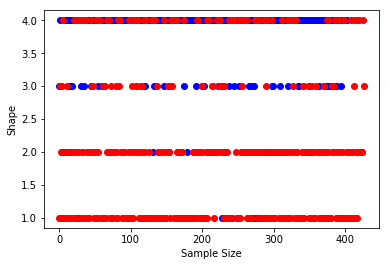

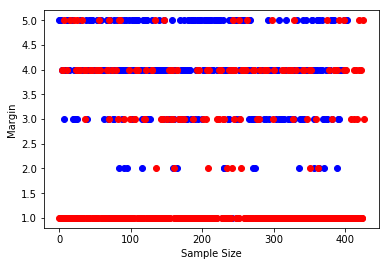

In [187]:
p_samp = list(np.where(y==1)[0])
n_samp = list(np.where(y==0)[0])
pp.figure()
pp.plot(X[p_samp,2], 'bo') 
pp.plot(X[n_samp,2], 'ro')
pp.xlabel('Sample Size')
pp.ylabel('Shape')
pp.figure()
pp.plot(X[p_samp,3], 'bo') # g for green, o for circle
pp.plot(X[n_samp,3], 'ro')
pp.xlabel('Sample Size')
pp.ylabel('Margin')
pp.show()

According to the Shape of mass histogram, when comparing benign and malignant samples, many benign samples have a 1(round) shape (red dots) while one can also see there are many blue dots(malignant) covering 3(lobular) and 4(irregular).

When looking at the mass of Margin histogram, one notices many red dots(benign) are 1 (circumscribed) while there are many blue dots(malignant) for 3(obscured), 4(ill-defined), and 5(spiculated)

Lastly, to visualize each of our 3 classifiers would help us have a better idea of which algorithm can naturally best fit the data

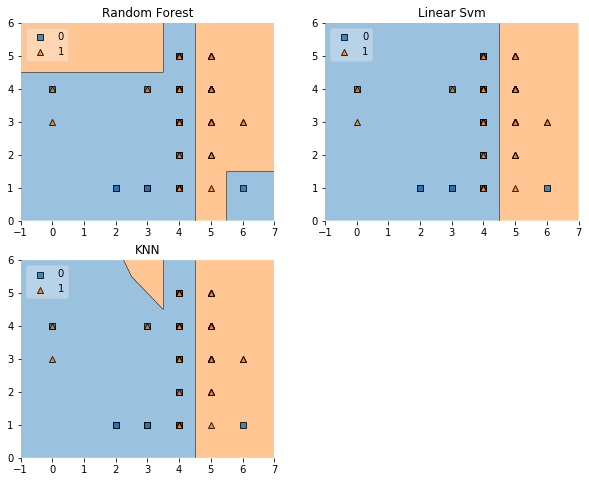

In [188]:

import matplotlib.gridspec as gridspec
import itertools
from mlxtend.classifier import EnsembleVoteClassifier

from mlxtend.plotting import plot_decision_regions

# Initializing Classifiers
clF1 = rfc(n_estimators=20, random_state=355)
value = 1.5
width = 0.75
C = 0.2
clF2 = svm.SVC(kernel='linear', C=C, probability=True)
clF3 = neighbors.KNeighborsClassifier(n_neighbors=9)
eclf = EnsembleVoteClassifier(clfs=[clF1, clF2, clF3],
                              weights=[2, 1, 1], voting='soft')


X2 = mmg[["BI-RADS", "Margin"]].values
X_tra = X2[:600]
X_te = X2[600:]
y_tra = y[:600]
y_te = y[600:]

X2 = preprocessing.StandardScaler().fit_transform(X2)

gs = gridspec.GridSpec(2, 2)
fig = pp.figure(figsize=(10, 8))

labels = ['Random Forest',
          'Linear Svm',
          'KNN']

i = 0
for clfx, lab, grd in zip([clF1, clF2, clF3],
                         labels,
                         itertools.product([0, 1],
                         repeat=2)):
    clfx.fit(X_tra, y_tra)
    ax = pp.subplot(gs[grd[0], grd[1]])
    #fig = plot_decision_regions(X, y=y, filler_feature_values={2: value, 3: value, 4: value}, filler_feature_ranges={2: width, 3: width, 4: width}, clf=clfx, legend=2)
    fig = plot_decision_regions(X_te, y_te, clf=clfx, legend=2)
    pp.title(lab)
    i = i+1
pp.show()

Just like our random forest classifier has proved, it does a pretty great job at separating the malignant(triangle) and benign(square) data points. The linear SVM and K-Nearest Neighbors does a good job but not nearly as accurate as the former classifier.

# After selecting the classifier, determining metrics, and selecting important features, we will now make observations of our data.

Now let's take a look at all of the malignant cases and see if there is any correlation to age

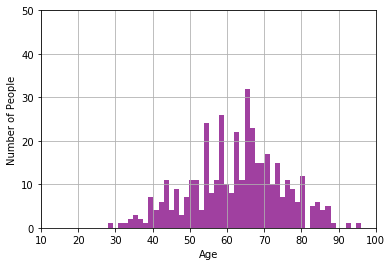

Number of samples in range 20 to 29 where severity is malignant: 1
Number of samples in range 30 to 39 where severity is malignant: 11
Number of samples in range 40 to 49 where severity is malignant: 50
Number of samples in range 50 to 59 where severity is malignant: 95
Number of samples in range 60 to 69 where severity is malignant: 128
Number of samples in range 70 to 79 where severity is malignant: 83
Number of samples in range 80 to 89 where severity is malignant: 33
Number of samples in range 90 to 99 where severity is malignant: 2
median age: 64


In [189]:
yes = list(np.where(y==1)[0])
X_age = X[yes]

#X_age[1].hist(figsize=[11,11])

#x = mu + sigma*np.random.randn(10000)

# the histogram of the data
n, bins, patches = pp.hist(X_age[:, 1], 50, facecolor='purple', alpha=0.75)

# add a 'best fit' line
#y = mlab.normpdf( bins, mu, sigma)
#l = plt.plot(bins, y, 'r--', linewidth=1)


#print X_age[:, 1]
#print np.mean(X_age[1])

pp.xlabel('Age')
pp.ylabel('Number of People')
#pp.title(r'$\mathrm{Histogram\ of\ IQ:}\ \mu=100,\ \sigma=15$')
pp.axis([10, 100, 0, 50])
pp.grid(True)

pp.show()


for i in range(2, 10):
    count = 0
    for j in X_age[:,1]:
        #print j
        if (j < ((i+1) * 10) and j >= (i * 10)):
            count += 1
    print ("Number of samples in range %d to %d where severity is malignant: %d" % (i*10, ((i+1)*10)-1, count))
    
print ("median age: %d" % (np.median(X_age[:,1])))

According to the histogram, the results display that the majority of samples with breast cancer age between 60 and 69; however many samples who have the disease are aged between 40-79. The median age of samples with breast cancer is 64.

Age is an important feature for determining severity but we will examine Shape, Margin, and Density.

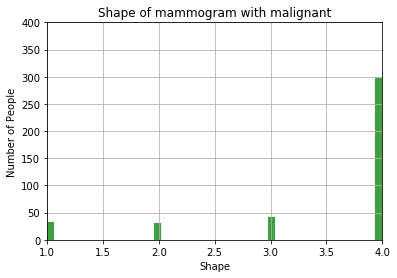

Number of samples that have shape 1 where severity is malignant: 32
Number of samples that have shape 2 where severity is malignant: 31
Number of samples that have shape 3 where severity is malignant: 42
Number of samples that have shape 4 where severity is malignant: 298


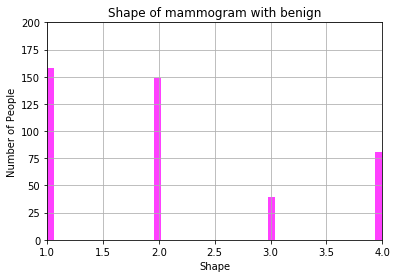

Number of samples that have shape 1 where severity is benign: 158
Number of samples that have shape 2 where severity is benign: 149
Number of samples that have shape 3 where severity is benign: 39
Number of samples that have shape 4 where severity is benign: 81


In [195]:
yes = list(np.where(y==1)[0])
#X_age = X[yes]
no = list(np.where(y==0)[0])

X3 = X[yes]
X4 = X[no]

#X_age[1].hist(figsize=[11,11])

#x = mu + sigma*np.random.randn(10000)

# the histogram of the data
n, bins, patches = pp.hist(X3[:, 2], 50, facecolor='green', alpha=0.75)

# add a 'best fit' line
#y = mlab.normpdf( bins, mu, sigma)
#l = plt.plot(bins, y, 'r--', linewidth=1)


#print X_age[:, 1]
#print np.mean(X_age[1])

pp.xlabel('Shape')
pp.ylabel('Number of People')
pp.title('Shape of mammogram with malignant')
pp.axis([1, 4, 0, 400])
pp.grid(True)

pp.show()


for i in range(1, 5):
    count = 0
    for j in X3[:,2]:
        #print j
        if (j == i):
            count += 1
    print ("Number of samples that have shape %d where severity is malignant: %d" % (i, count))
           
n, bins, patches = pp.hist(X4[:, 2], 50, facecolor='magenta', alpha=0.75)

# add a 'best fit' line
#y = mlab.normpdf( bins, mu, sigma)
#l = plt.plot(bins, y, 'r--', linewidth=1)


#print X_age[:, 1]
#print np.mean(X_age[1])

pp.xlabel('Shape')
pp.ylabel('Number of People')
pp.title('Shape of mammogram with benign')
pp.axis([1, 4, 0, 200])
pp.grid(True)

pp.show()


for i in range(1, 5):
    count = 0
    for j in X4[:,2]:
        #print j
        if (j == i):
            count += 1
    print ("Number of samples that have shape %d where severity is benign: %d" % (i, count))

If we recall from earlier each shape number correlates to a category: shape of mass is 1(round), 2(oval), 3(lobular), 4(irregular). When looking at the shape of malignant cases, most of the samples have an irregular shape while a majority of the samples where the severity is benign have a round or oval shape.

Next we compare positive and negative samples highlighting the Margin mass.

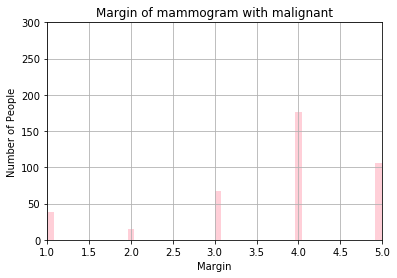

Number of samples that have margin 1 where severity is malignant: 38
Number of samples that have margin 2 where severity is malignant: 15
Number of samples that have margin 3 where severity is malignant: 67
Number of samples that have margin 4 where severity is malignant: 177
Number of samples that have margin 5 where severity is malignant: 106


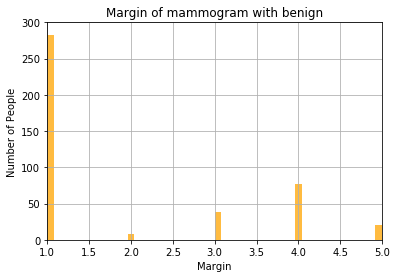

Number of samples that have margin 1 where severity is benign: 282
Number of samples that have margin 2 where severity is benign: 8
Number of samples that have margin 3 where severity is benign: 39
Number of samples that have margin 4 where severity is benign: 77
Number of samples that have margin 5 where severity is benign: 21


In [196]:
yes = list(np.where(y==1)[0])
#X_age = X[yes]
no = list(np.where(y==0)[0])

X3 = X[yes]
X4 = X[no]

#X_age[1].hist(figsize=[11,11])

#x = mu + sigma*np.random.randn(10000)

# the histogram of the data
n, bins, patches = pp.hist(X3[:, 3], 50, facecolor='pink', alpha=0.75)

# add a 'best fit' line
#y = mlab.normpdf( bins, mu, sigma)
#l = plt.plot(bins, y, 'r--', linewidth=1)


#print X_age[:, 1]
#print np.mean(X_age[1])

pp.xlabel('Margin')
pp.ylabel('Number of People')
pp.title('Margin of mammogram with malignant')
pp.axis([1, 5, 0, 300])
pp.grid(True)

pp.show()


for i in range(1, 6):
    count = 0
    for j in X3[:,3]:
        #print j
        if (j == i):
            count += 1
    print ("Number of samples that have margin %d where severity is malignant: %d" % (i, count))
           
n, bins, patches = pp.hist(X4[:, 3], 50, facecolor='orange', alpha=0.75)

# add a 'best fit' line
#y = mlab.normpdf( bins, mu, sigma)
#l = plt.plot(bins, y, 'r--', linewidth=1)


#print X_age[:, 1]
#print np.mean(X_age[1])

pp.xlabel('Margin')
pp.ylabel('Number of People')
pp.title('Margin of mammogram with benign')
pp.axis([1, 5, 0, 300])
pp.grid(True)

pp.show()


for i in range(1, 6):
    count = 0
    for j in X4[:,3]:
        #print j
        if (j == i):
            count += 1
    print ("Number of samples that have margin %d where severity is benign: %d" % (i, count))

Each number corresponds to the mass of the Margin: 1(circumscribed), 2(microlobulated), 3(obscured), 4(ill-defined), 5(spiculated). If a sample's severity is malignant it is common for their Margin mass to be ill-defined or spiculated where on the other side of the spectrum portrays that of the samples that are benign the common mass Margin is circumscribed.

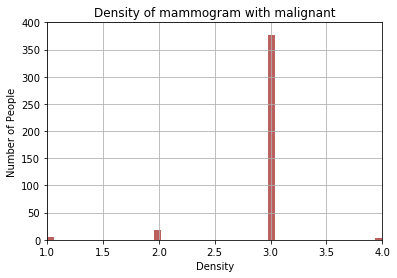

Number of samples that have density 1 where severity is malignant: 5
Number of samples that have density 2 where severity is malignant: 18
Number of samples that have density 3 where severity is malignant: 376
Number of samples that have density 4 where severity is malignant: 4


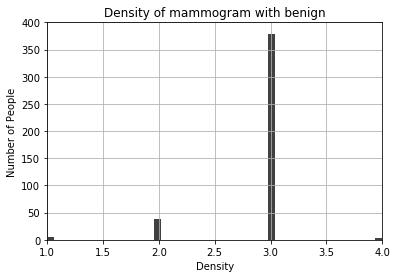

Number of samples that have density 1 where severity is benign: 6
Number of samples that have density 2 where severity is benign: 38
Number of samples that have density 3 where severity is benign: 379
Number of samples that have density 4 where severity is benign: 4


In [197]:
X5 = X[yes]
X6 = X[no]

#X_age[1].hist(figsize=[11,11])

#x = mu + sigma*np.random.randn(10000)

# the histogram of the data
n, bins, patches = pp.hist(X5[:, 4], 50, facecolor='brown', alpha=0.75)

# add a 'best fit' line
#y = mlab.normpdf( bins, mu, sigma)
#l = plt.plot(bins, y, 'r--', linewidth=1)


#print X_age[:, 1]
#print np.mean(X_age[1])

pp.xlabel('Density')
pp.ylabel('Number of People')
pp.title('Density of mammogram with malignant')
pp.axis([1, 4, 0, 400])
pp.grid(True)

pp.show()


for i in range(1, 5):
    count = 0
    for j in X5[:,4]:
        #print j
        if (j == i):
            count += 1
    print ("Number of samples that have density %d where severity is malignant: %d" % (i, count))
           
n, bins, patches = pp.hist(X6[:, 4], 50, facecolor='black', alpha=0.75)

# add a 'best fit' line
#y = mlab.normpdf( bins, mu, sigma)
#l = plt.plot(bins, y, 'r--', linewidth=1)


#print X_age[:, 1]
#print np.mean(X_age[1])

pp.xlabel('Density')
pp.ylabel('Number of People')
pp.title('Density of mammogram with benign')
pp.axis([1, 4, 0, 400])
pp.grid(True)

pp.show()


for i in range(1, 5):
    count = 0
    for j in X6[:,4]:
        #print j
        if (j == i):
            count += 1
    print ("Number of samples that have density %d where severity is benign: %d" % (i, count))

As expected from feature selection of the random forest classifier, both malignant and benign cases have a density of 3. Recall that the mass of density has 4 categories: 1(high), 2(iso), 3(low), 4(fat-containing). If both severities do not display significant discerning results then we realize this feature helps little with classification.

After looking at histograms of what is common in malignant and benign samples, we pair and compare the most common traits of malignant samples.

In [198]:
diff = list(np.where((X[:, 2]==4) & (X[:, 3]==4)))

X_new = X[diff]
y_new = y[diff]
#X_new = X[(X[:, 2]==4) & (X[:, 3]==4)]
#y_new = y[(X[:, 2]==4) & (X[:, 3]==4)]
#print X_new
#print y_new

count1 = 0
for e in y_new:
    if e == 1:
        count1 += 1
print ("X_new1 count: %d"% (X_new.shape[0]))
print ("# of malignant where shape = irregular and margin = illdefined: %d" % (count1))
res1 = float(count1)/X_new.shape[0]
print ("percentage of people malignant where shape = irregular and margin = illdefined: %f" %(float(res1)))
diff2 = list(np.where((X[:, 2]==4) & (X[:, 3]==5)))
X_new2 = X[diff2]
y_new2 = y[diff2]
count2 = 0
for e in y_new2:
    if e == 1:
        count2 += 1
print ("X_new2 count: %d"% (X_new2.shape[0]))
print ("# of malignant where shape = irregular and margin = spiculated: %d" % (count2))
res2 = float(count2)/X_new2.shape[0]
print ("percentage of people malignant where shape = irregular and margin = spiculated: %f" %(res2))

X_new1 count: 182
# of malignant where shape = irregular and margin = illdefined: 141
percentage of people malignant where shape = irregular and margin = illdefined: 0.774725
X_new2 count: 110
# of malignant where shape = irregular and margin = spiculated: 91
percentage of people malignant where shape = irregular and margin = spiculated: 0.827273


The first evaluation here shows that about 77.5% of samples that have the two features where the Shape of the mass is irregular and the Margin mass is illdefined have breast cancer. The second evaluation signifies that about 83% of samples that have Shape of the mass being irregular and a Margin mass that is spiculated have breast cancer.

This next evaluation specifies the Age, Shape, and Margin.

In [199]:
diff3 = list(np.where((X[:, 2]==4) & (X[:, 3]==4) & (X[:, 1]<70) & (X[:, 1]>=60)))
X_new3 = X[diff3]
y_new3 = y[diff3]
count3 = 0

for e in y_new3:
    if e == 1:
        count3 += 1
print ("X_new3 count: %d"% (X_new3.shape[0]))
print ("# of malignant where shape=irregular and margin=illdefined and age is between 60 and 69: %d" % (count3))   
res3 = float(count3)/X_new3.shape[0]
print ("percentage of people malignant where shape=irregular and margin=illdefined and age is between 60 and 69: %f" %(res3))

diff4 = list(np.where((X[:, 2]==4) & (X[:, 3]==5) & (X[:, 1]<70) & (X[:, 1]>=60)))
X_new4 = X[diff4]
y_new4 = y[diff4]
count4 = 0

for e in y_new4:
    if e == 1:
        count4 += 1
print ("X_new4 count: %d"% (X_new4.shape[0]))
print ("# of malignant where shape=irregular and margin=spiculated and age is between 60 and 69: %d" % (count4))   
res4 = float(count4)/X_new4.shape[0]
print ("percentage of people malignant where shape=irregular and margin=spiculated and age is between 60 and 69: %f" %(res4))

X_new3 count: 55
# of malignant where shape=irregular and margin=illdefined and age is between 60 and 69: 44
percentage of people malignant where shape=irregular and margin=illdefined and age is between 60 and 69: 0.800000
X_new4 count: 34
# of malignant where shape=irregular and margin=spiculated and age is between 60 and 69: 28
percentage of people malignant where shape=irregular and margin=spiculated and age is between 60 and 69: 0.823529


In this recent set of evlautions, we added another constraint where samples are between the age of 60 and 69. I decided this because this was the most common age group of samples where the severity is malignant. When the shape is irregular and margin is ill-defined, the percentage goes up about 2.5% of the severity being malignant. When the shape is irregular and the margin is spiculated the percentage stays roughly the same.

# Now What Does All This Mean?

Originally we had a sample size of 961 and after cleaning the data we have a reduced size of 830. Even though 830 is not a large set to determine whether mammographic masses are benign or malignant, it is a strong baseline to compare future unseen data to show whether certain features of a specific sample will predict if they have breast cancer. Ultimately, this data proves that if a patient is coming close to mammographic mass shape being irregular or mass of margin being spiculated/ill-defined or even if their age is in the 50-79 range, they could be seeing the early signs of breast cancer.

onehotencoding
(try linear scale and onehotencoding)

recall/precision

do not normalize certain factors(onehotenconding)

use randomforest feature selection

use margin and shape to help determine whether a person has severtity = 1 or not

http://scikit-learn.org/0.15/auto_examples/plot_learning_curve.html?fbclid=IwAR261Y0fy0HdgORvwQwIpSxPcd-_9uYjxG-vQ7tdWSPXpEhqIKvexer7k_I